In [3]:
#連接到雲端的資料夾, 只需執行一次
from google.colab import drive
drive.mount('/content/drive') #mount
#drive.flush_and_unmount() #unmount

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
#下載並引用一些會用到的套件
!pip install transformers
!pip install scikit-learn
from transformers import BertTokenizer, BertModel, BertForMaskedLM
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
import json
import pdb
import re
import pandas as pd
import numpy as np
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger') 
from nltk.stem import WordNetLemmatizer
from collections import Counter
from nltk.corpus import stopwords

     |████████████████████████████████| 2.3MB 3.9MB/s 
     |████████████████████████████████| 901kB 37.8MB/s 
     |████████████████████████████████| 3.3MB 41.2MB/s 
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [5]:
#讀檔
with open("/content/drive/Shareddrives/NLP/pubilc_data/train.json", 'r') as fin:
  TrainData = json.load(fin)
with open("/content/drive/Shareddrives/NLP/pubilc_data/eval.json", 'r') as fin:
  TestData = json.load(fin)

In [6]:
#split data, 先不要執行這個cell
#X1,X2 = train_test_split(TrainData, test_size=0.2)
#len(X1),len(X2),len(X2)/len(X1)
#TrainData = X1
#TestData = X2

In [7]:
#資料前處理
def Preprocess(rawData):
  prsData = pd.DataFrame(rawData)
  #將所有句子轉成小寫
  prsData['text'] = prsData['text'].str.lower()
  prsData['reply'] = prsData['reply'].str.lower()

  #刪掉網址
  prsData['text'] = prsData['text'].str.replace(r'https?:\/\/(www\.)?[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}\b([-a-zA-Z0-9()@:%_\+.~#?&//=]*)','')
  prsData['reply'] = prsData['reply'].str.replace(r'https?:\/\/(www\.)?[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}\b([-a-zA-Z0-9()@:%_\+.~#?&//=]*)','')
  
  #刪除stopwords
  stop_words = r'\b(?:{})\b'.format('|'.join(stopwords.words('english')))
  prsData['text'] = prsData['text'].str.replace(stop_words, '')
  prsData['reply'] = prsData['reply'].str.replace(stop_words, '')

  #只留下英文字母與@
  prsData['text'] = prsData['text'].str.replace(r'[^a-z @]', '')
  prsData['reply'] = prsData['reply'].str.replace(r'[^a-z @]', '')

  #刪掉人名
  prsData['text'] = prsData['text'].str.replace(r'@[a-z]+', ' ')
  prsData['reply'] = prsData['reply'].str.replace(r'@[a-z]+', ' ')

  #只留下最多一個空白
  prsData['text'] = prsData['text'].str.replace(r'\s+', ' ')
  prsData['reply'] = prsData['reply'].str.replace(r'\s+', ' ')

  
  #還原字型 eg. 複數 -> 單數; 動詞三態 -> 現在式, 這個尚未定義, 如果知道怎麼做的話麻煩幫忙加一下
  '''wnl = WordNetLemmatizer()
  for text in prsData['text']:
    tokens = nltk.word_tokenize(text)# 分詞
    tagged_sent = nltk.pos_tag(tokens)# 獲取單詞詞性
    lemmas_sent = []
    for tag in tagged_sent:
      wordnet_pos = get_wordnet_pos(tag[1]) or wordnet.NOUN
      lemmas_sent.append(wnl.lemmatize(tag[0],pos=wordnet_pos)) # 詞形還原
    prsData['text']=lemmas_sent
  #prsData['reply']=wnl.lemmatize(prsData['reply'])'''

  return prsData

In [8]:
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

In [9]:
#建立keywords字典 by TF-IDF
def GenFakeKeywordList(prsData,dictSize=256):
  vectorizer = CountVectorizer()
  tfidf_transformer = TfidfTransformer()  
  
  #將所有fake news合成一個文件, 所有real news合成另一個文件, 參考: https://chih-sheng-huang821.medium.com/機器學習應用-垃圾訊息偵測-與-tf-idf介紹-含範例程式-2cddc7f7b2c5
  fakeData = prsData[prsData['label'] == 'fake']
  realData = prsData[prsData['label'] == 'real']

  #應該還可再優化加速, 可我想不到了, 知道怎麼做的話也麻煩幫忙處理一下
  textIdx = -1
  fakeDataText = ""
  for i in range(len(fakeData)):
    if textIdx != fakeData.iloc[i]['idx']:
      fakeDataText = fakeDataText + fakeData.iloc[i]['text'] #concate text
      textIdx = fakeData.iloc[i]['idx']
    fakeDataText = fakeDataText + fakeData.iloc[i]['reply'] #concate reply
  
  textIdx = -1
  realDataText = ""
  for i in range(len(realData)):
    if textIdx != realData.iloc[i]['idx']:
      realDataText = realDataText + realData.iloc[i]['text'] #concate text
      textIdx = realData.iloc[i]['idx']
    realDataText = realDataText + realData.iloc[i]['reply'] #concate reply

  fakeRealDataText = [fakeDataText] + [realDataText]
  
  
  #取出fake news的keywords
  tfidf_fake_real_data = tfidf_transformer.fit_transform(vectorizer.fit_transform(fakeRealDataText))
  fake_keywords_score = (tfidf_fake_real_data[0]-tfidf_fake_real_data[1]).toarray() #fake - real
  indices = np.argsort(fake_keywords_score).reshape(-1)[-dictSize:][::-1] #從score大的排到score小的
  fake_keywords = np.array(vectorizer.get_feature_names())[indices] #取出fake_keywords_score大的words

  return fake_keywords

In [10]:
#為每個content建立vector, 若包含重要的詞就設為1, 不包含就設為0
def featurized(prsData,keywords): 
  #將data轉成只包含keywords的樣子, 小心shallow copy的問題
  #except_keywords = r'\b(?!(?:{})\b)\w+'.format('|'.join(keywords))
  #print(prsData['reply'],end="\n\n")
  #print(prsData['reply'].str.replace(except_keywords, 'x')) #將不在keyword list裡面的word都替換掉

  #將同一篇text的reply集合成一個document
  docIdxs = prsData['idx'].drop_duplicates().index
  documents = prsData['text'][docIdxs]
  for i in range(len(docIdxs)):
    for j in prsData[prsData['idx'] == prsData['idx'][docIdxs[i]]].index: #取得所有第i個document的reply的index as j
      documents[docIdxs[i]] = documents[docIdxs[i]] + prsData['reply'][j] #設置第i個document的內容
  
  
  #將同一document根據keywords建立vector
  features = np.zeros((len(documents),len(keywords)))
  for i in range(len(documents)):
    for word in documents.iloc[i].split(' '):
      if word in fake_keywords:
        features[i,np.where(word==fake_keywords)] = 1

  return features

In [11]:
#output格式正確的答案
def submission(predict,Data):
  subData = pd.DataFrame([])
  subData['idx'] = Data['idx']
  subData['context_idx'] = Data['context_idx']
  subData['label'] = ""
  docIdxs = Data['idx'].drop_duplicates().index
  for i in range(len(docIdxs)):
    
    mask = (subData['idx'] == Data['idx'].loc[Data['idx'].drop_duplicates().index[i]])
    subData.loc[mask,'label'] = predict[i]
  
  return subData

In [12]:
 #前置處理
prsTrainData = Preprocess(TrainData)
#print(prsTrainData.iloc[0:3])
fake_keywords = GenFakeKeywordList(prsTrainData,dictSize=1024)
#print(fake_keywords)
featureTrain = featurized(prsTrainData,fake_keywords)
#print(np.sum(np.sum(featureTrain,axis = 1) > 0) / featureTrain.shape[0]) #含有fake_keyword的document的比例

#用機器學習模型對vector們做分類
#model = BernoulliNB() #NaiveBayes
#model.fit(featureTrain,prsTrainData['label'][prsTrainData['idx'].drop_duplicates().index].values) #NaiveBayes
model = SVC(kernel='rbf') #SVM
model.fit(featureTrain, pd.factorize(prsTrainData['label'][prsTrainData['idx'].drop_duplicates().index].values)[0]) #SVM
predictTrain = model.predict(featureTrain)
#train_accuracy = np.sum(predictTrain == prsTrainData['label'][prsTrainData['idx'].drop_duplicates().index].values) / prsTrainData['idx'].drop_duplicates().shape[0]
#print(train_accuracy)
#print(np.sum(predictTrain=='fake') / predictTrain.shape[0])

#預測test data
prsTestData = Preprocess(TestData)
featureTest = featurized(prsTestData,fake_keywords)
#print(np.sum(np.sum(featureTest,axis = 1) > 0) / featureTest.shape[0]) #含有fake_keyword的document的比例
predictTest = model.predict(featureTest)
predictTest = predictTest.astype(str) #SVM
predictTest[predictTest == '0'] = 'fake' #SVM
predictTest[predictTest == '1'] = 'real' #SVM
#test_accuracy = np.sum(predictTest == prsTestData['label'][prsTestData['idx'].drop_duplicates().index].values) / prsTestData['idx'].drop_duplicates().shape[0]
#print(test_accuracy)
#print(np.sum(predictTest=='fake') / predictTest.shape[0])
subData = submission(predictTest,pd.DataFrame(TestData))
subData.to_csv("/content/drive/Shareddrives/NLP/output_data/eval.csv", index =False)

In [20]:
prsTestData.var()

idx            491820.700307
context_idx      2263.707023
dtype: float64

In [17]:
#debug

#submission 格式是用 idx 來做分類, 所以這裡也用idx來分, 注意不能用text來分, 因為同一個idx不一定有著同一個text
print(prsTrainData['idx'].drop_duplicates().shape)
print(pd.DataFrame(TrainData)['idx'].drop_duplicates().shape)

#同一個idx不一定同一個text
np.where(pd.DataFrame(TrainData)['text'] == '#FactCheck  It is believed that ancestor of #KamalaHarris was the infamous white slave owner in Jamaica Hamilton Brown. Although fact-checkers have already branded it as , we provide here irrefutable proof that her ancestors were slave owners. https://t.co/dJAi5PYuRi')
np.where(pd.DataFrame(TrainData)['idx'] == 26609)
print(pd.DataFrame(TrainData).iloc[65570]) #idx = 26609, text = '#FactCheck  It is believed that ancestor of #KamalaHarris was the infamous white slave owner in Jamaica Hamilton Brown. Although fact-checkers have already branded it as , we provide here irrefutable proof that her ancestors were slave owners. https://t.co/dJAi5PYuRi'
print(pd.DataFrame(TrainData).iloc[161839]) #idx = 10996, text = '#FactCheck  It is believed that ancestor of #KamalaHarris was the infamous white slave owner in Jamaica Hamilton Brown. Although fact-checkers have already branded it as , we provide here irrefutable proof that her ancestors were slave owners. https://t.co/dJAi5PYuRi'

#經過process的data可能會變成空字串
np.where(pd.DataFrame(TrainData)['text'].drop_duplicates().index[:5000] != prsTrainData['text'].drop_duplicates().index[:5000])
print(pd.DataFrame(TrainData)['text'].drop_duplicates()[570:])
print(prsTrainData['text'].drop_duplicates()[570:])

(35018,)
(35018,)
idx                                                        26609
text           #FactCheck  It is believed that ancestor of #K...
categories                                                    []
context_idx                                                    3
reply          @GreatGameIndia So what?! It was her ancestors...
mp4                                                             
label                                                       fake
Name: 65570, dtype: object
idx                                                        10996
text           #FactCheck  It is believed that ancestor of #K...
categories          [seriously, smh, sigh, idk, shrug, facepalm]
context_idx                                                    3
reply          @Bucaneer13 @GreatGameIndia https://t.co/7gSp0...
mp4                                      1358398932485767172.mp4
label                                                       fake
Name: 161839, dtype: object
22374     The med

'scale'

In [14]:
#目前有兩種演算法思路
#=========第一種=========
#1. 計算前 n 個重要的詞 by TF-IDF
#2. 為每個content建立vector, 若包含重要的詞就設為1, 不包含就設為0, 此步驟會將text轉成0、1 number的vector
#3. 用機器學習模型對vector們做分類 eg. NaiveBayes, SVM, Kmeans
#=========第二種=========
#1. 計算前 n 個重要的詞 by TF-IDF
#2. 將每個content改寫成只包含重要的詞的形式, 不重要的詞就丟掉
#3. 利用bert tokenizer將步驟2 output出來的content轉成vector, 注意bert最多只能處理512個詞
#4. sol1. 用機器學習做分類 eg. NaiveBayes, SVM, Kmeans
#   sol2. 定義一個loss function, 用bert layer跟一些其他network layer去做gradient optimize, 直到loss function收斂

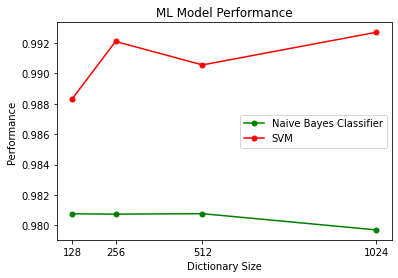

In [15]:
import matplotlib.pyplot as plt
NB_performance = [0.98075717354,0.9807352805,0.9807662527,0.9796977112]
SVM_performance = [0.9883080028,0.9920991931,0.9905534886,0.9927041201]
dict_size = [128,256,512,1024]
plt.title("ML Model Performance")
plt.xlabel("Dictionary Size")
plt.ylabel("Performance")
plt.xticks(dict_size,dict_size)
plt.plot(dict_size,NB_performance,color='green',marker='o', markersize=5)
plt.plot(dict_size,SVM_performance,color='red',marker='o', markersize=5)
plt.legend(['Naive Bayes Classifier', 'SVM'])
plt.show()